In [1]:
!pip install -U fastai

     |████████████████████████████████| 189 kB 23.1 MB/s            
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
from fastai.data.external import untar_data,URLs
from fastai.data.transforms import get_image_files

In [3]:
path = "/data/notebook_files/Data"
files = get_image_files(path)
files[0]

Path('/data/notebook_files/Data/Cars/Car Greyscale/Car (40)_gray.jpg')

In [4]:
import PIL

In [5]:
img = PIL.Image.open(files[0])
img.show

<bound method Image.show of <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1024x547 at 0x7F8A977899D0>>

In [6]:
import  torch
import numpy as np

In [7]:
def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(np.array(img)))
    return t.permute(2,0,1).float()/255.0

In [8]:
open_image(files[0]).shape

torch.Size([3, 224, 224])

In [9]:
import re

In [10]:
def label_func(fname):
    return (re.match(r"^(.*).jpg$", fname.name).groups()[0])



label_func(files[23])

'PoliceCar (47)_gray'

In [11]:
labels = list(set(files.map(label_func)))
len(labels)

105

In [12]:
lbl2files = {l: [f for f in files if label_func(f) == l] for l in labels}

In [13]:
import random
import PIL

In [14]:
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
        
    def __getitem__(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (img1, img2, torch.Tensor([same]).squeeze())
    
    def __len__(self): return len(self.files)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls]) 
        return random.choice(lbl2files[cls]),same

In [15]:
idxs = np.random.permutation(range(len(files)))
cut = int(0.8 * len(files))
train_files = files[idxs[:cut]]
valid_files = files[idxs[cut:]]

In [16]:
train_ds = SiameseDataset(train_files)
valid_ds = SiameseDataset(valid_files, is_valid=True)

In [17]:
from fastai.data.core import DataLoaders

In [18]:
dls = DataLoaders.from_dsets(train_ds, valid_ds)

In [19]:
b = dls.one_batch()

In [20]:
dls = dls.cuda()

In [21]:
from fastai.vision.all import *

In [22]:
class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
        
    def encodes(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (TensorImage(img1), TensorImage(img2), torch.Tensor([same]).squeeze())
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls]) 
        return random.choice(lbl2files[cls]),same

In [23]:
train_tl= TfmdLists(range(len(train_files)), SiameseTransform(train_files))
len(train_tl)
valid_tl= TfmdLists(range(len(valid_files)), SiameseTransform(valid_files, is_valid=True))
len(valid_tl)

21

In [24]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, 
                             after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])
dls = dls.cuda()

In [25]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

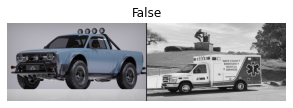

In [31]:
img = PILImage.create(files[87])
img1 = PILImage.create(files[12])
s = SiameseImage(img, img1, False)
s.show();

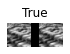

In [30]:
tst = Resize(30)(s)
tst = ToTensor()(tst)
tst.show();

In [28]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [{l: [f for f in files[splits[i]] if label_func(f) == l] for l in labels}
                          for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
    def encodes(self, f):
        f2,same = self.valid.get(f, self._draw(f,0))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, same)
    
    def _draw(self, f, split=0):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(self.splbl2files[split][cls]),same

In [29]:
splits = RandomSplitter()(files)
SiameseTransform(files, splits)

IndexError: IndexError: Cannot choose from an empty sequence

In [65]:
valids = [v[0] for k,v in tfm.valid.items()]      
assert not [v for v in valids if v in files[splits[0]]]

NameError: NameError: name 'tfm' is not defined